# Лабораторна робота №1
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**

1.   Встановлені Python та бібліотеки PyTorch, torchvision, matplotlib.
2.   Завантажений набір даних CIFAR-10.

## Завдання до лабораторної роботи (частина І): Робота з даними (CIFAR-10)

1.   Імпортуйте необхідні бібліотеки:
```
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
```
2.   Завантаження даних. Напишіть функцію, яка завантажує набір даних CIFAR-10.
3.   Перевірка наявності даних. Напишіть код, який перевіряє, чи дані завантажені та розпаковані успішно. Виведіть повідомлення про статус завантаження.
4.   Підготовка даних. Напишіть код, щоб імплементувати трансформації для зображень:
*    перетворення в тензори;
*    денормалізація (при необхідності).  

Використайте `torchvision.transforms` для підготовки даних.
5.   Створення DataLoader. Створіть DataLoader для навчального та тестового наборів даних, щоб спростити процес завантаження даних за батчами.
6.   Візуалізація прикладів:
*   напишіть функцію для візуалізації деяких зображень з набору даних;
*   відобразіть кілька зображень з їхніми реальними мітками.
7.   Ваші висновки до частини І.

## Завдання до лабораторної роботи (частина ІІ):
0. Розділіть набір даних на навчальний і тестовий.
1. Визначення структури FNN (Fully-connected neural network).
    - Створіть клас для цільної нейронної мережі, яка буде містити мінімум два повнозв'язних шари.
2. Вибір функції втрати та оптимізатора:
    - визначте функцію втрат (наприклад, CrossEntropyLoss) та оптимізатор (наприклад, SGD або Adam).
3. Тренування моделі.
    - Реалізуйте цикл навчання, де:
        - модель тренується на навчальному наборі даних;
        - виводиться значення функції втрат та точність (на навчальній та валідаційній множинах) після кожної епохи.
4. Оцінка моделі:
    - визначте точність моделі на тестовому наборі даних;
    - виведіть детальні статистики (загальна точність та точність для кожного класу).
5. Візуалізація результатів:
    - візуалізуйте кілька випадкових передбачених зображень разом з їхніми реальними мітками та передбаченнями;
    - побудуйте графік точності та втрат для навчального набору даних на кожній епосі.

## Додаткові завдання (за бажанням):

- Напишіть код, який виведе кількість зображень у кожному класі в директорії train. Для цього ви можете використовувати os.listdir() для підрахунку зображень у відповідних піддиректоріях.
- Створіть графік (наприклад, гістограму), який відображає кількість зображень в кожному класі. Ви можете використовувати бібліотеку matplotlib для візуалізації.
- Виведіть кілька випадкових зображень з кожного класу разом із їхніми мітками.
- Дослідіть, як зміна параметрів підготовки даних (наприклад, різні трансформації) впливає на результати моделі.
- Спробуйте змінити архітектуру моделі (додати додаткові шари) та проаналізуйте, як це впливає на результати.
- Включіть регуляризацію (наприклад, Dropout) для покращення загальної точності.


In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchsummary import summary 

# Додаткове завдання

- аугментація даних, додати конфюжн метрікс
- зробити окремі трансформації на трейн та на тест
- early stopping, prevent from overfitting
- Oversampling, undersampling
- зважені метрики?
- чим більший датасет, тим більше батчу можна дозволити


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(torch.version.cuda)
print(torch.__version__)
print(device) 

NVIDIA GeForce GTX 1070
1
11.8
2.0.1+cu118
cuda


In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
os.getcwd()

'C:\\Users\\Cyberpower\\PycharmProjects\\modelTraining\\DL4CV\\2025'

In [94]:
data_train = torchvision.datasets.CIFAR10(root="Datasets", train=True, download=True, transform= transform_test)
data_test = torchvision.datasets.CIFAR10(root="Datasets", train=False, download=True, transform= transform_test)

Files already downloaded and verified
Files already downloaded and verified


## EDA

In [95]:
print(f"Train data: {len(data_train)} images")
print(f"Test data: {len(data_test)} images")

Train data: 50000 images
Test data: 10000 images


In [96]:
def get_average_brightness(image):
    return np.mean(image)

data = []

for img, label in data_train:
    width, height = img.shape[1:]
    img = img.view(-1).numpy()
    average_brightness = get_average_brightness(img)
    data.append([width, height, label, average_brightness])

df_train = pd.DataFrame(data, columns=['Width', 'Height', 'Label', 'AverageBrightness'])

In [97]:
df_train.describe()

,Width,Height,Label,AverageBrightness
count,50000.0,50000.0,50000.00000,50000.000000
mean,32.0,32.0,4.50000,-0.053274
std,0.0,0.0,2.87231,0.250533
min,32.0,32.0,0.00000,-0.938166
25%,32.0,32.0,2.00000,-0.220376
50%,32.0,32.0,4.50000,-0.067473
75%,32.0,32.0,7.00000,0.096725
max,32.0,32.0,9.00000,0.978799


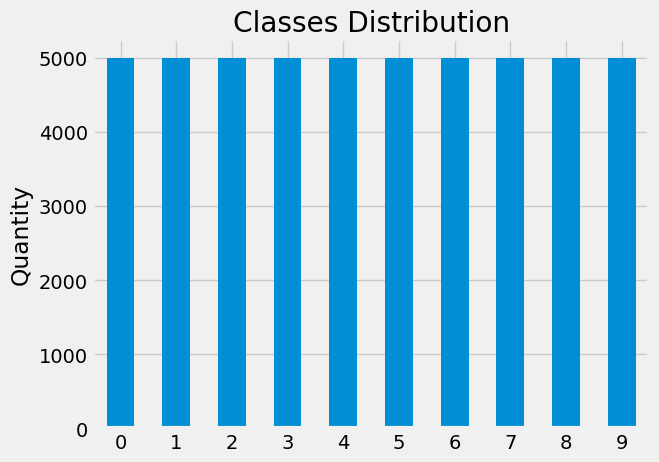

In [98]:
plt.style.use('fivethirtyeight')
df_train['Label'].sort_values(ascending=True).value_counts().plot(kind='bar', title='Classes Distribution')
plt.xticks(rotation=0)
plt.ylabel('Quantity')
plt.show()

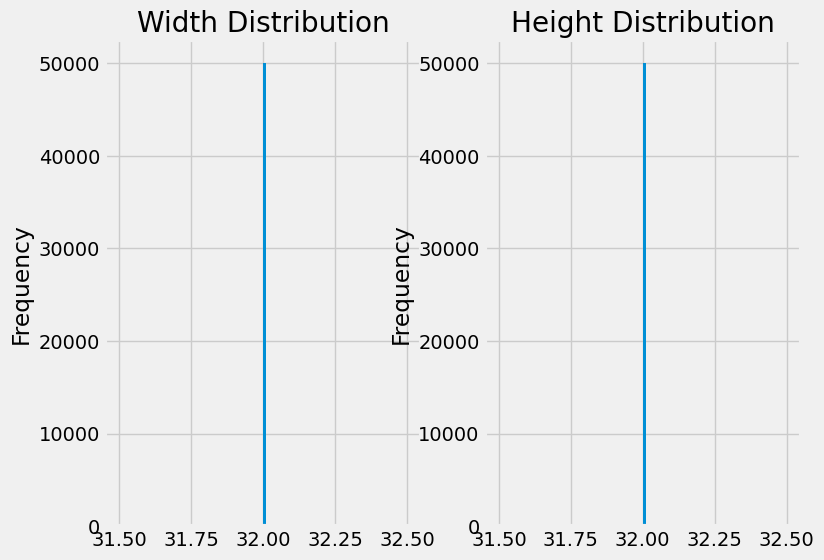

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

df_train['Width'].plot(ax=ax[0], kind='hist', bins = 100)
ax[0].set_title('Width Distribution')

df_train['Height'].plot(ax=ax[1], kind='hist', bins = 100)
ax[1].set_title('Height Distribution')

plt.show()

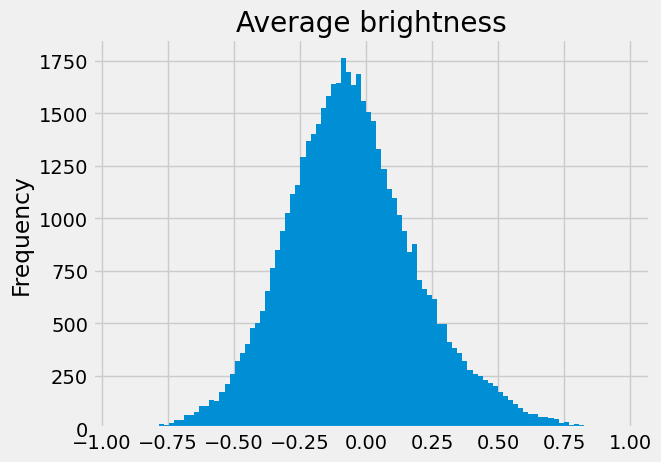

In [100]:
df_train['AverageBrightness'].plot(kind='hist', bins=100, title='Average brightness');

In [101]:
val_size = 5000
train_size = len(data_train) - val_size

train_dataset, valid_dataset = random_split(data_train, [train_size, val_size])

In [102]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32, num_workers=2, pin_memory=True)

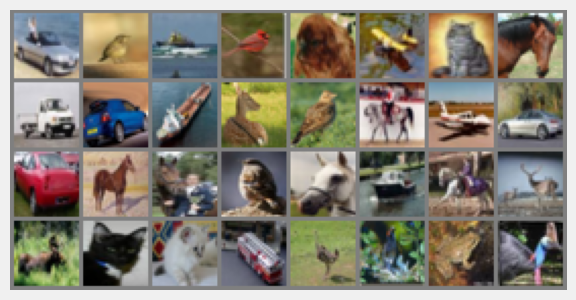

Labels: [1, 2, 8, 2, 5, 0, 3, 7, 9, 1, 8, 4, 2, 7, 0, 1, 1, 7, 7, 2, 7, 8, 7, 4, 4, 3, 3, 9, 2, 2, 6, 2]


In [103]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (if normalization was applied)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor format
    plt.axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', labels.tolist()) 

In [104]:
class SequentialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self,x):
        x = x.view(x.size(0), -1)
        return self.layer(x)

In [105]:
def train(model, optimizer, criterion, train_loader, epoch, log_interval=20):
    # Set model to training mode
    model.train()

    correct = 0
    total = 0

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data.item(),
                100. * correct / total))


In [106]:
def validate(model, criterion, validation_loader, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [107]:
model = SequentialModel()

In [108]:
model.to(device)
summary(model, input_size=(3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 256]         262,400
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 10]           2,570
Total params: 3,411,722
Trainable params: 3,411,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 13.01
Estimated Total Size (MB): 13.05
----------------------------------------------------------------


In [109]:
batch_size = 32
loss_func = nn.CrossEntropyLoss()
epochs=30

In [110]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size,  num_workers=2)
validation_loader = DataLoader(dataset=valid_dataset, shuffle=False)
test_loader = DataLoader(dataset=data_test, shuffle=True, batch_size=batch_size,  num_workers=2)
        
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = loss_func

lossv, accv = [], []
for epoch in range(1, epochs+1):
    train(model, optimizer, criterion, train_loader, epoch)
    validate(model, criterion, validation_loader, lossv, accv)

	Accuracy: 9.38%0/45000 (0%)]	Loss: 2.309141
	Accuracy: 23.07%40/45000 (1%)]	Loss: 2.059925
	Accuracy: 25.38%280/45000 (3%)]	Loss: 2.207369
	Accuracy: 27.25%920/45000 (4%)]	Loss: 1.654863
	Accuracy: 29.48%560/45000 (6%)]	Loss: 1.923048
	Accuracy: 29.70%200/45000 (7%)]	Loss: 2.253158
	Accuracy: 30.86%840/45000 (9%)]	Loss: 2.026725
	Accuracy: 31.01%480/45000 (10%)]	Loss: 2.060641
	Accuracy: 31.25%120/45000 (11%)]	Loss: 1.628930
	Accuracy: 31.66%760/45000 (13%)]	Loss: 1.841646
	Accuracy: 32.07%400/45000 (14%)]	Loss: 1.906276
	Accuracy: 32.57%040/45000 (16%)]	Loss: 1.983484
	Accuracy: 33.00%680/45000 (17%)]	Loss: 1.702627
	Accuracy: 33.37%320/45000 (18%)]	Loss: 1.623745
	Accuracy: 33.75%960/45000 (20%)]	Loss: 1.405322
	Accuracy: 33.94%600/45000 (21%)]	Loss: 1.810154
	Accuracy: 34.28%0240/45000 (23%)]	Loss: 1.505481
	Accuracy: 34.60%0880/45000 (24%)]	Loss: 2.003690
	Accuracy: 34.61%1520/45000 (26%)]	Loss: 1.746486
	Accuracy: 35.13%2160/45000 (27%)]	Loss: 1.559393
	Accuracy: 35.30%2800/45000

In [111]:
def test():
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    #Total accuracy
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    # Accuracy for each class
    for i in range(10):
        acc = 100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0
        print(f'Accuracy for class {i}: {acc:.2f}%')
    
    # Results
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(lossv, label="Valid Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(accv, label="Valid Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    plt.show()
    
def imshow(img):
    img = img.cpu().numpy()
    img = np.squeeze(img)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    plt.figure(figsize=(10, 5))
    
    for i in range(10):
        plt.subplot(2, 5, i+1)
        imshow(images[i])
        plt.title(f'Pred: {preds[i].item()} | True: {labels[i].item()}')
    plt.show()

Test Accuracy: 50.97%
Accuracy for class 0: 46.60%
Accuracy for class 1: 65.60%
Accuracy for class 2: 36.60%
Accuracy for class 3: 47.90%
Accuracy for class 4: 39.10%
Accuracy for class 5: 36.30%
Accuracy for class 6: 56.10%
Accuracy for class 7: 56.40%
Accuracy for class 8: 72.60%
Accuracy for class 9: 52.50%


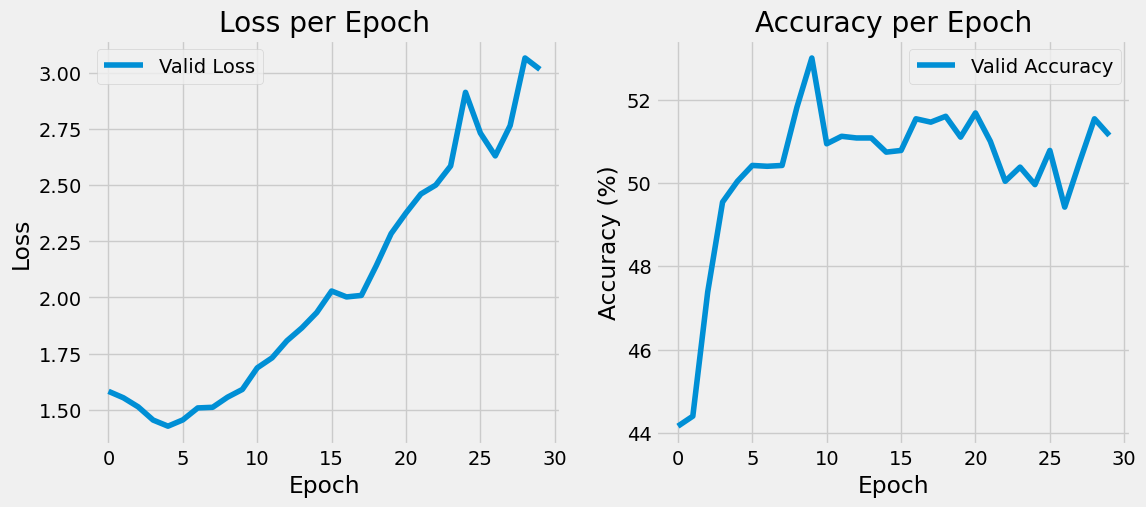

In [112]:
test()